In [ ]:
import torch
import torch.nn as nn
import numpy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import save_image

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
from google.colab import drive
drive.mount('/content/drive')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Assignment 2',transform = transform)
dataloader_train = DataLoader(dataset,batch_size=1, shuffle=False)

with open('/content/drive/MyDrive/class label/imagenet1000_clsidx_to_labels.txt') as f:
  classes_train = [line.strip() for line in f.readlines()]
def label_alexnet(model,dataloader,labels):
  class_label=[]
  model.eval()
  for (data,_) in (dataloader):
    with torch.no_grad():
      out = model(data)
      _, predicted = torch.max(out, 1)
      class_label.append(labels[predicted[0]])
  return class_label
label_alexnet(model,dataloader_train,classes_train)

["457: 'bow tie, bow-tie, bowtie',",
 "601: 'hoopskirt, crinoline',",
 "107: 'jellyfish',",
 "29: 'axolotl, mud puppy, Ambystoma mexicanum',",
 "6: 'stingray',",
 "318: 'lacewing, lacewing fly',",
 "619: 'lampshade, lamp shade',",
 "601: 'hoopskirt, crinoline',",
 "311: 'grasshopper, hopper',",
 "904: 'window screen',"]

### Question 1 part(c)

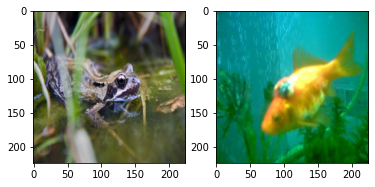

original label number first image 311: 'grasshopper, hopper',
original label number second image 107: 'jellyfish',


In [ ]:
image1 = dataset[8][0]
image2 = dataset[2][0]
plt.subplot(121)
plt.imshow(image1.permute(1,2,0))
plt.subplot(122)
plt.imshow(image2.permute(1,2,0))
plt.show()
out1 = model(image1.unsqueeze(0))
_, predicted = torch.max(out1, 1)
print('original label number first image',classes_train[predicted])
out2 = model(image2.unsqueeze(0))
_, predicted = torch.max(out2, 1)
print('original label number second image',classes_train[predicted])

In [ ]:
def generate_adversarial_image(model, image, target_class, alpha=0.1, num_iterations=1000):

    # Create a random noise image to start the optimization
    r = torch.ones_like(image, requires_grad=True)
    r = r/10
    r = torch.tensor(r,requires_grad=True)
    # Define the optimizer
    optimizer = torch.optim.Adam([r], lr=0.01)

    y_target = torch.tensor(target_class)
    for i in range(num_iterations):

        optimizer.zero_grad()
        # Compute the perturbed image

        x_perturbed = image + r

        # Get the model predictions for the perturbed image
        y_pred = model(x_perturbed.unsqueeze(0))
        _, predicted = torch.max(y_pred, 1)
        # Compute the cross-entropy loss between the predicted and target labels
        loss = F.cross_entropy(y_pred.squeeze(), y_target)

        # Add L1 regularization to encourage sparsity in the perturbations
        loss += alpha * r.abs().sum()

        loss.backward()

        # Update the perturbations using the Adam optimizer
        optimizer.step()

        # Check if the sample has switched to a new class
        if y_pred.argmax() in y_target:
            break
    # Return the adversarial image

    return x_perturbed

In [ ]:
target_classes1 = [288, 319, 835]  # Random classes: 'leopard', 'dragonfly', 'sunidal'
target_classes2 = [692, 919, 968]  # Random classes: 'packet', 'bookshop', 'cup'
# Generate adversarial examples for image 1
adversarial_images1 = []
adversarial_images2 = []
i=0
for y_target in target_classes1:
  adversarial_image = generate_adversarial_image(model, image1.clone(), y_target, alpha=.05, num_iterations=500)
  save_image(adversarial_image, 'img'+str(i)+'.png')
  i+=1
  adversarial_images1.append(adversarial_image)

for y_target in target_classes2:
  i+=1
  adversarial_image = generate_adversarial_image(model, image1.clone(), y_target, alpha=.05, num_iterations=500)
  save_image(adversarial_image, 'img'+str(i)+'.png')
  adversarial_images2.append(adversarial_image)

<ipython-input-7-1865417b1ab1>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(r,requires_grad=True)


In [ ]:
for i in range(len(adversarial_images1)):
  adv = adversarial_images1[i]
  y_pred = model(adv.unsqueeze(0))
  _, predicted = torch.max(y_pred, 1)
  print(classes_train[predicted])

288: 'leopard, Panthera pardus',
319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
835: 'sundial',


In [ ]:
for i in range(len(adversarial_images2)):
  adv = adversarial_images2[i]
  y_pred = model(adv.unsqueeze(0))
  _, predicted = torch.max(y_pred, 1)
  print(classes_train[predicted])

692: 'packet',
438: 'beaker',
968: 'cup',


# 🦜 NN-Based Language Model
In this excercise we will run a basic RNN based language model and answer some questions about the code. It is advised to use GPU to run the code. First run the code then answer the questions below that require modifying it.

In [ ]:
#@title 🧮 Imports & Hyperparameter Setup
#@markdown Feel free to experiment with the following hyperparameters at your
#@markdown leasure. For the purpose of this assignment, leave the default values
#@markdown and run the code with these suggested values.
# Some part of the code was referenced from below.
# https://github.com/pytorch/examples/tree/master/word_language_model
# https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model

! git clone https://github.com/yunjey/pytorch-tutorial/
%cd pytorch-tutorial/tutorials/02-intermediate/language_model/

import torch
import torch.nn as nn
import numpy as np
from torch.nn.utils import clip_grad_norm_

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
embed_size = 128 #@param {type:"number"}
hidden_size = 1024 #@param {type:"number"}
num_layers = 1 #@param {type:"number"}
num_epochs = 5 #@param {type:"slider", min:1, max:10, step:1}
batch_size = 20 #@param {type:"number"}
seq_length = 30 #@param {type:"number"}
learning_rate = 0.002 #@param {type:"number"}
#@markdown Number of words to be sampled ⬇️
num_samples = 50 #@param {type:"number"}

print(f"--> Device selected: {device}")


Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 28.50 MiB/s, done.
Resolving deltas: 100% (491/491), done.
/content/pytorch-tutorial/tutorials/02-intermediate/language_model
--> Device selected: cuda


In [ ]:
from data_utils import Dictionary, Corpus

# Load "Penn Treebank" dataset
corpus = Corpus()
ids = corpus.get_data('data/train.txt', batch_size)
vocab_size = len(corpus.dictionary)
num_batches = ids.size(1) // seq_length

print(f"Vcoabulary size: {vocab_size}")
print(f"Number of batches: {num_batches}")

Vcoabulary size: 10000
Number of batches: 1549


## 🤖 Model Definition
As you can see below, this model stacks `num_layers` many [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) units vertically to construct our basic RNN-based language model. The diagram below shows a pictorial representation of the model in its simplest form (i.e `num_layers`=1).
![Pictorial Representation of The Model](https://upload.wikimedia.org/wikipedia/commons/6/63/Long_Short-Term_Memory.svg)

In [ ]:
# RNN based language model
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h):
        # Embed word ids to vectors
        x = self.embed(x)

        # Forward propagate LSTM
        out, (h, c) = self.lstm(x, h)

        # Reshape output to (batch_size*sequence_length, hidden_size)
        out = out.reshape(out.size(0)*out.size(1), out.size(2))

        # Decode hidden states of all time steps
        out = self.linear(out)
        return out, (h, c)

## 🏓 Training
In this section we will train our model, this should take a couple of minutes! Be patient 😊

In [ ]:
model = RNNLM(vocab_size, embed_size, hidden_size, num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states]


# Train the model
for epoch in range(num_epochs):
    # Set initial hidden and cell states
    states = (torch.zeros(num_layers, batch_size, hidden_size).to(device),
              torch.zeros(num_layers, batch_size, hidden_size).to(device))

    for i in range(0, ids.size(1) - seq_length, seq_length):
        # Get mini-batch inputs and targets
        inputs = ids[:, i:i+seq_length].to(device)
        targets = ids[:, (i+1):(i+1)+seq_length].to(device)

        # Forward pass
        states = detach(states)
        outputs, states = model(inputs, states)
        loss = criterion(outputs, targets.reshape(-1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        step = (i+1) // seq_length
        if step % 100 == 0:
            print ('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                   .format(epoch+1, num_epochs, step, num_batches, loss.item(), np.exp(loss.item())))

Epoch [1/5], Step[0/1549], Loss: 9.2117, Perplexity: 10013.88
Epoch [1/5], Step[100/1549], Loss: 6.0125, Perplexity: 408.49
Epoch [1/5], Step[200/1549], Loss: 5.9158, Perplexity: 370.86
Epoch [1/5], Step[300/1549], Loss: 5.7582, Perplexity: 316.77
Epoch [1/5], Step[400/1549], Loss: 5.7180, Perplexity: 304.29
Epoch [1/5], Step[500/1549], Loss: 5.0992, Perplexity: 163.90
Epoch [1/5], Step[600/1549], Loss: 5.1736, Perplexity: 176.55
Epoch [1/5], Step[700/1549], Loss: 5.3578, Perplexity: 212.26
Epoch [1/5], Step[800/1549], Loss: 5.1680, Perplexity: 175.56
Epoch [1/5], Step[900/1549], Loss: 5.0558, Perplexity: 156.92
Epoch [1/5], Step[1000/1549], Loss: 5.1087, Perplexity: 165.46
Epoch [1/5], Step[1100/1549], Loss: 5.3379, Perplexity: 208.07
Epoch [1/5], Step[1200/1549], Loss: 5.1878, Perplexity: 179.07
Epoch [1/5], Step[1300/1549], Loss: 5.1308, Perplexity: 169.15
Epoch [1/5], Step[1400/1549], Loss: 4.8015, Perplexity: 121.70
Epoch [1/5], Step[1500/1549], Loss: 5.1591, Perplexity: 174.01
Ep

# 🤔 Questions

## 1️⃣ Q2.1 Detaching or not? (10 points)
The above code implements a version of truncated backpropagation through time. The implementation only requires the `detach()` function (lines 7-9 of the cell) defined above the loop and used once inside the training loop.
* Explain the implementation (compared to not using truncated backprop through time).
* What does the `detach()` call here achieve? Draw a computational graph. You may choose to answer this question outside the notebook.
* When using using line 7-9 we will typically observe less GPU memory being used during training, explain why in your answer.


## 🔮 Model Prediction
Below we will use our model to generate text sequence!

In [ ]:
# Sample from the model
with torch.no_grad():
    with open('sample.txt', 'w') as f:
        # Set intial hidden ane cell states
        state = (torch.zeros(num_layers, 1, hidden_size).to(device),
                 torch.zeros(num_layers, 1, hidden_size).to(device))

        # Select one word id randomly
        prob = torch.ones(vocab_size)
        input = torch.multinomial(prob, num_samples=1).unsqueeze(1).to(device)

        for i in range(num_samples):
            # Forward propagate RNN
            output, state = model(input, state)

            # Sample a word id
            prob = output.exp()
            word_id = torch.multinomial(prob, num_samples=1).item()

            # Fill input with sampled word id for the next time step
            input.fill_(word_id)

            # File write
            word = corpus.dictionary.idx2word[word_id]
            word = '\n' if word == '<eos>' else word + ' '
            f.write(word)

            if (i+1) % 100 == 0:
                print('Sampled [{}/{}] words and save to {}'.format(i+1, num_samples, 'sample.txt'))
! cat sample.txt

retailers on medical cooperatives 
shortly even the near santa fe and johnson is supposed to be directly drawn for some time 
on wall street securities generally posted some light gains much competition 
ford might are favor to boost rates from before taking further <unk> with fears of 

## 2️⃣ Q2.2 Sampling strategy (7 points)
Consider the sampling procedure above. The current code samples a word:
```python
word_id = torch.multinomial(prob, num_samples=1).item()
```
in order to feed the model at each output step and feeding those to the next timestep. Copy below the above cell and modify this sampling startegy to use a greedy sampling which selects the highest probability word at each time step to feed as the next input.

In [ ]:
# Sample greedily from the model
import torch.nn.functional as F

with torch.no_grad():
    with open('sample.txt', 'w') as f:
        # Set intial hidden ane cell states
        state = (torch.zeros(num_layers, 1, hidden_size).to(device),
                 torch.zeros(num_layers, 1, hidden_size).to(device))

        # Select one word id randomly
        prob = torch.ones(vocab_size)
        input = torch.multinomial(prob, num_samples=1).unsqueeze(1).to(device)

        for i in range(num_samples):
            # Forward propagate RNN
            output, state = model(input, state)

            # Sample a word id
            prob = output.exp()
            word_high = (F.softmax(prob,dim=1)).argmax().item()
            input.fill_(word_high)

            # File write
            word = corpus.dictionary.idx2word[word_high]
            word = '\n' if word == '<eos>' else word + ' '
            f.write(word)

            if (i+1) % 100 == 0:
                print('Sampled [{}/{}] words and save to {}'.format(i+1, num_samples, 'sample.txt'))
! cat sample.txt

for the company 
mr. roman will retire the team 's bloated <unk> 
he said he would retire hearings with his own N years 
he said he would n't elaborate 
mr. roman 's departure may be a good prospect for the company 
mr. roman appears <unk> 

## 3️⃣ Q2.3 Embedding Distance (8 points)
Our model has learned a specific set of word embeddings.
* Write a function that takes in 2 words and prints the cosine distance between their embeddings using the word embeddings from the above models.
* Use it to print the cosine distance of the word "army" and the word "taxpayer".

*Refer to the sampling code for how to output the words corresponding to each index. To get the index you can use the function `corpus.dictionary.word2idx.`*


In [ ]:
# Embedding distance

def cosine_distance(word1, word2, model):
  idx1 = corpus.dictionary.word2idx[word1]
  idx2 = corpus.dictionary.word2idx[word2]
  emb1,_ = model(torch.tensor(idx1).unsqueeze(0).unsqueeze(0).to(device),state)
  emb2,_ = model(torch.tensor(idx2).unsqueeze(0).unsqueeze(0).to(device),state)
  cos_sim = F.cosine_similarity(emb1, emb2, dim=1)
  return cos_sim.item()

cosine_distance('army', 'taxpayer', model)


0.9493026733398438

## 4️⃣ Q2.4 Teacher Forcing (Extra Credit 2 points)
What is teacher forcing?
> Teacher forcing works by using the actual or expected output from the training dataset at the current time step $y(t)$ as input in the next time step $X(t+1)$, rather than the output generated by the network.

In the `🏓 Training` code this is achieved, implicitly, when we pass the entire input sequence (`inputs = ids[:, i:i+seq_length].to(device)`) to the model at once.

Copy below the `🏓 Training` code and modify it to disable teacher forcing training. Compare the performance of this model, to original model, what can you conclude? (compare perplexity and convergence rate)

In [ ]:
# Training code with Teacher Forcing

## 5️⃣ Q2.5 Distance Comparison (+1 point)
Repeat the work you did for `3️⃣ Q2.3 Embedding Distance` for the model in `4️⃣ Q2.4 Teacher Forcing` and compare the distances produced by these two models (i.e. with and without the teacher forcing), what can you conclude?

### Question 3 part (d)

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, Z):
        # Z has shape (B, T, Din)
        batch_size, seq_len, input_dim = Z.size()
        Z = Z.view(-1, input_dim)  # reshape to (B*T, Din)
        H = self.relu(self.linear1(Z))  # apply linear1 and relu
        out = self.linear2(H)  # apply linear2
        out = out.view(batch_size, seq_len, input_dim)  # reshape back to (B, T, Din)
        return out

class PositionWiseFeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(PositionWiseFeedForward, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim,stride = 1, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv1d_2 = nn.Conv1d(in_channels=hidden_dim, out_channels=input_dim,stride = 1, kernel_size=1)

    def forward(self, Z):
        # Z has shape (B, T, Din)
        Z = Z.permute(0, 2, 1)  # permute to (B, Din, T)
        H = self.relu(self.conv1d(Z))  # apply conv1d and relu
        out = self.conv1d_2(H)  # apply conv1d_2
        out = out.permute(0, 2, 1)  # permute back to (B, T, Din)
        return out

# Create a random tensor Z with size (2, 3, 4)
Z = torch.randn(2, 3, 4)

# Test using nn.Linear
pwff_nn_linear = PositionWiseFeedForward(input_dim=4, hidden_dim=8)
out_nn_linear = pwff_nn_linear(Z)
assert out_nn_linear.size() == (2, 3, 4)

# Test using nn.Conv1d
pwff_conv1d = PositionWiseFeedForward(input_dim=4, hidden_dim=8)
out_conv1d = pwff_conv1d(Z)
assert out_conv1d.size() == (2, 3, 4)
print("Validation passed!")


Validation passed!
